In [2]:
# imports
import spacy
import numpy as np
import pandas as pd



In [3]:
nlp = spacy.load('en_core_web_sm')


In [4]:
#getting the data
df = pd.read_csv("data/wiki_sentences_v2.csv")
pd.set_option('display.max_colwidth', 200)
df

,sentence
0,"confused and frustrated, connie decides to leave on her own."
1,"later, a woman’s scream is heard in the distance."
2,christian is then paralyzed by an elder.
3,the temple is set on fire.
4,"outside, the cult wails with him."
...,...
4313,"confidencial also responded negatively, calling the film a barren drama, unsubtle and self-indulgent."
4314,and le parisien gave the film their highest five-star rating.
4315,"the museum collection includes 37,000 film titles, 60,000 posters, 700,000 photographs and 20,000 books."
4316,"its predecessor was the dutch historical film archive, founded in 1946."


In [5]:
sent = "m global was also circling to bid for the film's international sales rights."
doc = nlp(sent)
for tok in doc:
    print(tok.text, "--", tok.dep_)

m -- nsubj
global -- amod
was -- aux
also -- advmod
circling -- ROOT
to -- aux
bid -- xcomp
for -- prep
the -- det
film -- poss
's -- case
international -- amod
sales -- compound
rights -- pobj
. -- punct


In [6]:
#getting the entities in our graph(subject & object)
def get_entities(sent):
    ##chunk 1
    ent1, ent2 = "", ""
    prv_token_dep = ""
    prv_token_txt = ""

    prefix, modifier = "", ""
    for tok in nlp(sent):
        if tok.dep_ == "punct":
            continue
        if tok.dep_ == "compound":
            prefix = tok.text
            if prv_token_dep == "compund":
                prefix = prv_token_txt + " " + tok.text
        if tok.dep_.endswith("mod") == True:
            modifier = tok.text
            if prv_token_dep == "compound":
                modifier = prv_token_txt + " " + tok.text
        if tok.dep_.find("subj") == True:
            ent1 = modifier + " " + prefix + " " + tok.text
            prv_token_dep = ""
            prv_token_txt = ""
            prefix, modifier = "", ""

        if tok.dep_.find("obj") == True:
            ent2 = modifier + " " + prefix + " " + tok.text

        prv_token_dep = tok.dep_
        prv_token_txt = tok.text
    return [ent1.strip(), ent2.strip()]


In [7]:
get_entities("it will be done by Arya")

['it', 'Arya']

In [8]:
from tqdm import tqdm

entity_pairs = list()

for sent in tqdm(df["sentence"]):
    entity_pairs.append(get_entities(sent))

100%|██████████| 4318/4318 [00:21<00:00, 203.25it/s]


In [9]:
print(entity_pairs[10:20])
print(df["sentence"][10:20])

[['we', 'tests'], ['m', 'international sales rights'], ['canadian robbie robertson', 'soundtrack'], ['it', 'existing music tracks'], ['it', 'reviewed  franchise'], ['she', 'accidentally  mystique'], ['military  forces', 'arrest'], ['train', 'vuk'], ['', 'selene gallio'], ['singer', 'sequel']]
10                                       we went through all these tests and things  
11       m global was also circling to bid for the film's international sales rights.
12                      canadian musician robbie robertson supervised the soundtrack.
13                               it features both original and existing music tracks.
14                                    it is the worst reviewed film in the franchise.
15    but she injures quicksilver and accidentally kills mystique before flying away.
16                                            military forces tasked with her arrest.
17                                the train is attacked by vuk and her d'bari forces.
18                

In [10]:
#now gettting the relationships
from spacy.matcher import Matcher
from spacy.tokens import Span

def get_relation(sent):
    doc = nlp(sent)
    matcher = Matcher(nlp.vocab)
    pattern = [{"DEP": "ROOT"},
               {"DEP": "prep", "OP": "?"},
               {"DEP": "agent", "OP": "?"},
               {"POS" : "ADJ", "OP": "?"}]
    matcher.add("Relation", [pattern])
    macthes = matcher(doc)
    for match_id, start, end in macthes:
        span = doc[start:end]
        return span.text
    

In [11]:
sent = "Arya completed the job"
doc = nlp(sent)
for tok in doc:
    print(tok.text, "  ", tok.dep_)

Arya    nsubj
completed    ROOT
the    det
job    dobj


In [12]:
sent = "Arya completed the job"
get_relation(sent)


'completed'

In [13]:
relations = [get_relation(sent) for sent in tqdm(df["sentence"])]

100%|██████████| 4318/4318 [00:22<00:00, 192.78it/s]


In [14]:
pd.Series(relations).value_counts()

is              420
was             348
released        166
are              98
were             92
               ... 
flipped           1
forsaken          1
investigates      1
condoled          1
garbo             1
Length: 1045, dtype: int64

In [15]:
sub = [ent[0] for ent in entity_pairs]
obj = [ent[1] for ent in entity_pairs]

new_df = pd.DataFrame({"Subject": sub, "Object": obj, "Edge":relations})
new_df.head(20)

,Subject,Object,Edge
0,connie,own,decides
1,woman scream,distance,heard
2,christian,then elder,paralyzed
3,temple,fire,set
4,,outside cult him,wails
5,it,religious awakening,'s
6,craig vincent,cast,joined
7,later di francia,action cast,revealed
8,sebastian maniscalco,later ben cast,revealed
9,we,just film,tried


In [16]:
import networkx as nx
import matplotlib.pyplot as plt
G = nx.from_pandas_edgelist(new_df, "Subject", "Object", edge_attr="Edge", create_using= nx.MultiDiGraph())
print(G.number_of_edges())
print(new_df.shape)
G.number_of_nodes()
# too much computation
# plt.figure(figsize = (15, 15))
# nx.draw(G, with_labels = True, node_color = "red", pos = nx.spring_layout(G))
# plt.show()

4318
(4318, 3)


4910

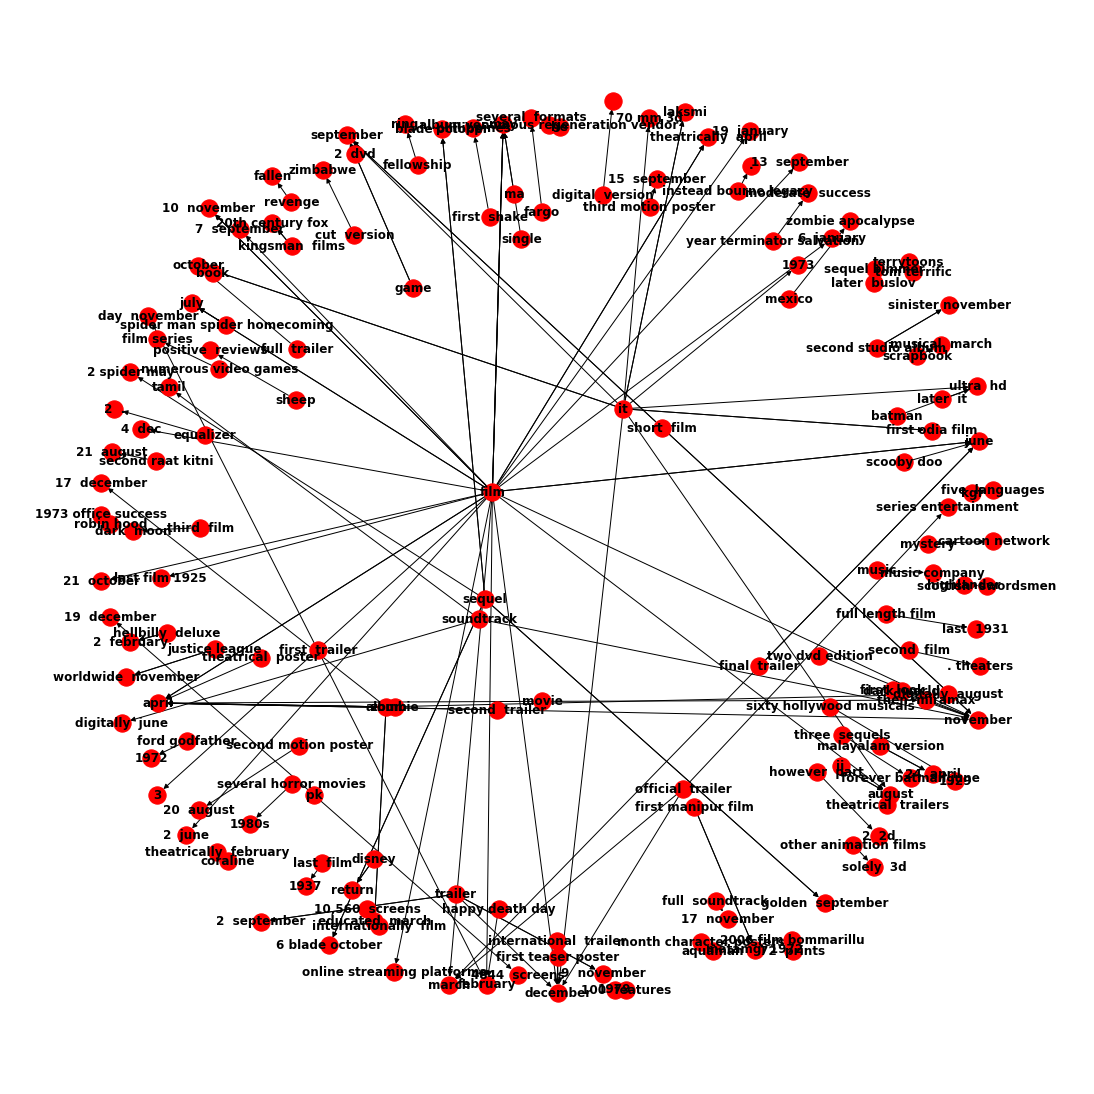

In [21]:
G = nx.from_pandas_edgelist(new_df[new_df.Edge == "released"], "Subject", "Object", edge_attr="Edge", create_using= nx.MultiDiGraph())
plt.figure(figsize = (15, 15))
nx.draw(G, with_labels = True, node_color = "red", pos = nx.spring_layout(G), font_weight = "bold")
plt.show()

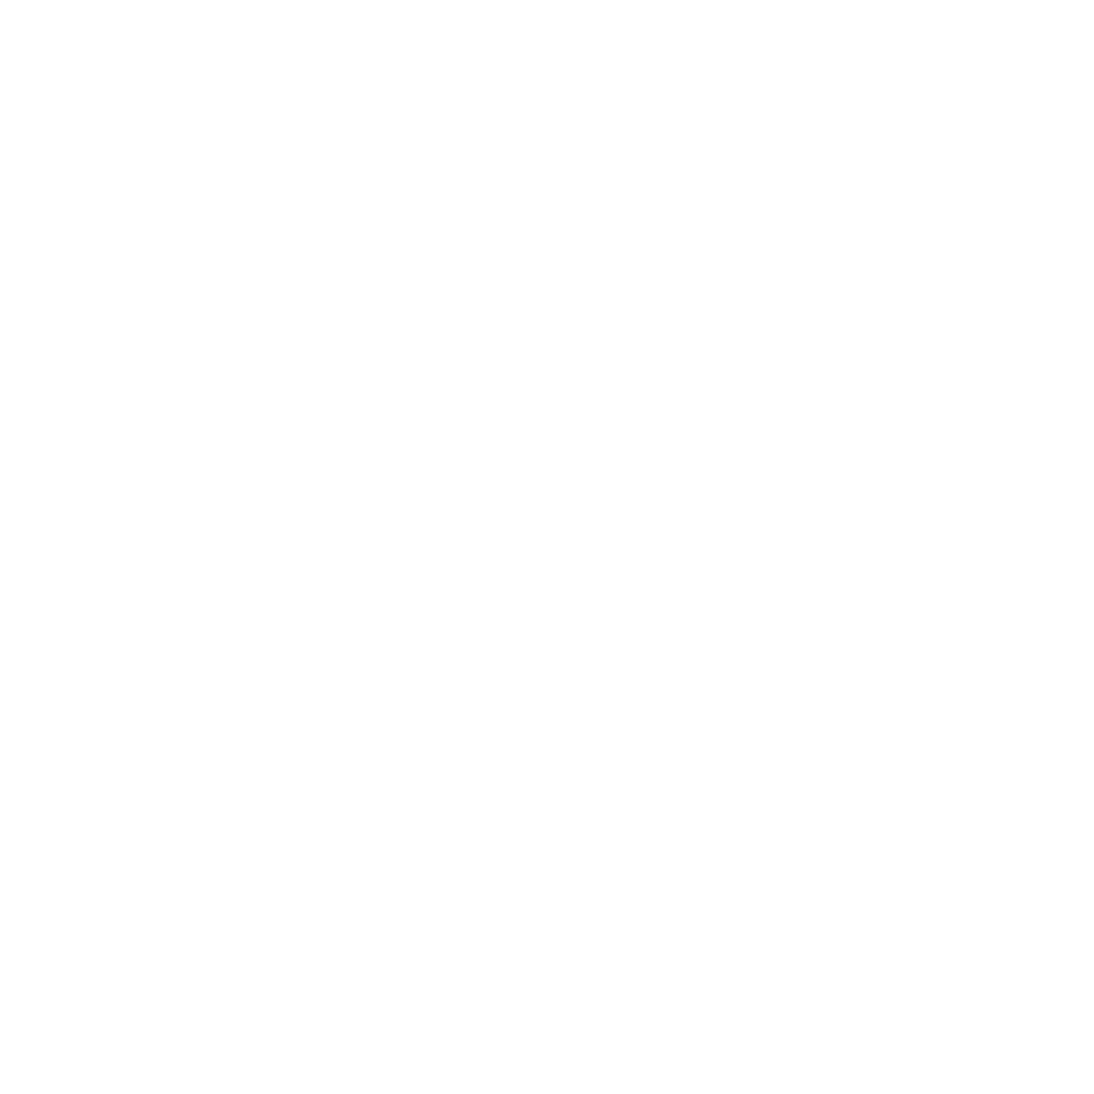

In [28]:
G = nx.from_pandas_edgelist(new_df[new_df.Edge == "released"], "Subject", "Object", edge_attr="Edge", create_using= nx.MultiDiGraph())
plt.figure(figsize = (15, 15))
nx.draw(G, with_labels = True, node_color = "red", pos = nx.spring_layout(G), font_weight = "bold")
plt.show()

In [25]:
pd.Series(relations).value_counts()[:50]

is            420
was           348
released      166
are            98
were           92
include        80
's             48
produced       48
made           46
used           42
composed       40
became         37
included       33
have           33
began          32
become         32
has            32
received       28
considered     27
been           27
be             27
directed       27
written        26
had            25
called         22
shot           22
set            21
known          21
cast           20
introduced     20
stars          20
went           19
announced      18
opened         18
scheduled      17
hired          16
started        16
wrote          15
developed      14
starred        14
shown          13
includes       13
provided       12
wanted         12
completed      12
features       12
based          12
ended          12
won            12
done           12
dtype: int64